In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import torch
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, make_scorer)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import reuters
from tensorflow.keras.layers import (Activation, Conv2D, Conv2DTranspose,
                                     Dense, Dropout, Flatten,
                                     GlobalAveragePooling2D, Input,
                                     MaxPooling2D)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Transformación de las imágenes

In [2]:
# Define the data transformation to apply to the images
h, w = (830, 500)

data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.Resize((h, w)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Load the dataset using ImageFolder
data_dir = 'dataset_images/'
dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

# Create a DataLoader to handle batching and shuffling of data
batch_size = 32
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


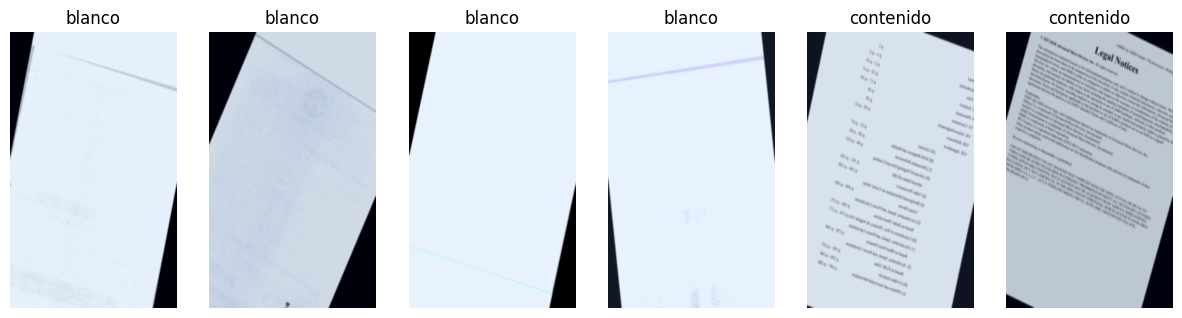

In [3]:
# Get a batch of images and their corresponding labels from the DataLoader
images, labels = next(iter(data_loader))
denormalized_images = (images * 0.225) + 0.406

# Plot the images
fig, axs = plt.subplots(1, 6, figsize=(15, 5))
for i in range(6):
    image = denormalized_images[i].permute(1, 2, 0)  # Convert the tensor back to (H, W, C) format
    label = dataset.classes[labels[i]]  # Get the class label

    axs[i].imshow(image)
    axs[i].set_title(label)
    axs[i].axis('off')

plt.show()

In [4]:
# Split the dataset into training, validation, and testing sets
train_size = int(0.8 * len(dataset))        # Use 80% of the data for training
val_size = int(0.1 * len(dataset))          # Use 10% of the data for validation
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for training, validation, and testing sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Convert PyTorch tensors to numpy arrays
def torch_to_numpy(loader):
    all_data = []
    all_labels = []
    for data, labels in loader:
        all_data.append(data.numpy())
        all_labels.append(labels.numpy())
    return np.concatenate(all_data), np.concatenate(all_labels)

X_train, y_train = torch_to_numpy(train_loader)
X_val, y_val = torch_to_numpy(val_loader)
X_test, y_test = torch_to_numpy(test_loader)

X_train = np.transpose(X_train, (0, 2, 3, 1))
X_val = np.transpose(X_val, (0, 2, 3, 1))
X_test = np.transpose(X_test, (0, 2, 3, 1))

In [8]:
base_model = InceptionV3(
    include_top=False,
    weights="imagenet", 
    input_shape=(h, w, 3),
)

In [9]:
base_model.trainable = False
output_bm = base_model.output
flatten = Flatten()(output_bm)

In [10]:
output_shape = len(dataset.classes)
class_layer = GlobalAveragePooling2D()(output_bm)
class_layer = Dense(512, activation = "relu")(class_layer)
class_layer = Dropout(0.1)(class_layer)
class_layer = Dense(256, activation = "relu")(class_layer)
class_layer = Dropout(0.1)(class_layer)
output_class = Dense(output_shape, activation ="sigmoid", name ='label')(class_layer)

In [11]:
pretrained_inceptionV3_model = Model(inputs=base_model.input, outputs=[output_class])

In [12]:
pretrained_inceptionV3_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 830, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 414, 249, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 414, 249, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                             

In [13]:
lr = 1e-3
optimizer = Adam(learning_rate=lr)

In [14]:
pretrained_inceptionV3_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
early_stopping = EarlyStopping(monitor='loss', patience=5)
callbacks = [early_stopping]

In [16]:
pretrained_inceptionV3_model_history = pretrained_inceptionV3_model.fit(X_train,
                                                                        y_train,
                                                                        epochs=200,
                                                                        validation_data = (X_val,
                                                                                           y_val),
                                                                        callbacks=callbacks
                                                                       )

Epoch 1/200
7/7 [==============================] - 29s 2s/step - loss: 0.5612 - accuracy: 0.7766 - val_loss: 0.2304 - val_accuracy: 0.8750
Epoch 2/200
7/7 [==============================] - 5s 675ms/step - loss: 0.2672 - accuracy: 0.9137 - val_loss: 0.1702 - val_accuracy: 0.9583
Epoch 3/200
7/7 [==============================] - 5s 674ms/step - loss: 0.1820 - accuracy: 0.9137 - val_loss: 0.2700 - val_accuracy: 0.9167
Epoch 4/200
7/7 [==============================] - 5s 677ms/step - loss: 0.1137 - accuracy: 0.9543 - val_loss: 0.0420 - val_accuracy: 0.9583
Epoch 5/200
7/7 [==============================] - 5s 683ms/step - loss: 0.1049 - accuracy: 0.9645 - val_loss: 0.1052 - val_accuracy: 0.9583
Epoch 6/200
7/7 [==============================] - 5s 679ms/step - loss: 0.0627 - accuracy: 0.9746 - val_loss: 0.0111 - val_accuracy: 1.0000
Epoch 7/200
7/7 [==============================] - 5s 685ms/step - loss: 0.0631 - accuracy: 0.9746 - val_loss: 0.0857 - val_accuracy: 0.9583
Epoch 8/200
7/7

In [17]:
pretrained_inceptionV3_val = pretrained_inceptionV3_model.evaluate(X_val, y_val)
print('Validation loss: {:4f}\nValidation Accuracy: {:4f}'.format(pretrained_inceptionV3_val[0], pretrained_inceptionV3_val[1]))

1/1 [==============================] - 1s 686ms/step - loss: 1.7239e-05 - accuracy: 1.0000
Validation loss: 0.000017
Validation Accuracy: 1.000000


In [18]:
pretrained_inceptionV3_test = pretrained_inceptionV3_model.evaluate(X_test, y_test)
print('Test loss: {:4f}\nTest Accuracy: {:4f}'.format(pretrained_inceptionV3_test[0], pretrained_inceptionV3_test[1]))

1/1 [==============================] - 4s 4s/step - loss: 0.0046 - accuracy: 1.0000
Test loss: 0.004591
Test Accuracy: 1.000000


In [19]:
pretrained_inceptionV3_predicted = pretrained_inceptionV3_model.predict(X_test).argmax(axis=1)
print('Reporte para el modelo construido')
print(classification_report(y_test, pretrained_inceptionV3_predicted))

1/1 [==============================] - 3s 3s/step
Reporte para el modelo construido
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00         8

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26

